In [ ]:
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Bidirectional, LSTM, GRU, SimpleRNN, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Load the data
df = pd.read_csv('collected_base_spk_embeddings.csv')

# Normalize sensor data
cols = df.shape[1]
scaler = MinMaxScaler()
df[cols] = scaler.fit_transform(df[cols])

print("Normalized data sample:")
print(df.head())

In [61]:
# Creates sequence data for RNN
def create_sequences_data(df, sensor_cols, seq_length):
    num_cases = len(df) // seq_length   # 10,000
    data = df[sensor_cols].values[:num_cases*seq_length]
    X, y = [], []

    for case in range(num_cases):
        start = case * seq_length
        end = start + seq_length
        block = data[start:end]

        # Create sliding windows within this block
        # Each sequence will be seq_length-1 timesteps predicting the next timestep
        seq_x = block[:seq_length - 1]  # input: 59 timesteps
        seq_y = block[seq_length - 1]    # target: next timestep
        X.append(seq_x)
        y.append(seq_y)

    return np.array(X), np.array(y)



# Hyperparameters
seq_length = 60   # how many past timesteps to use as input
input_size = len(sensor_cols)  # number of features = 5

# Create dataset
X, y = create_sequences_data(df, sensor_cols, seq_length)
print("X shape:", X.shape)  # (num_samples, 60, 5)
print("y shape:", y.shape)  # (num_samples, 5)

X shape: (10000, 59, 5)
y shape: (10000, 5)


In [62]:
# Split into training (80%) and test (20%)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True
)

print("Training shape:", X_train.shape, y_train.shape)
print("Test shape:", X_test.shape, y_test.shape)

Training shape: (8000, 59, 5) (8000, 5)
Test shape: (2000, 59, 5) (2000, 5)


In [63]:
# Define all the models to test
models = {
    # 0.01132
    "GRU_128_64": Sequential([
        GRU(128, return_sequences=True, input_shape=(seq_length, input_size)),
        Dropout(0.2),
        GRU(64),
        Dense(input_size)
    ]),
}

histories = {}
evaluations = {}

for name, model in models.items():
    print(f"\nTraining model: {name}")
    print("===============================")
    model.compile(optimizer='adam', loss='mean_absolute_error')
    
    history = model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=100,
        batch_size=32*2,
        verbose=1
    )
    
    histories[name] = history

    # Evaluate the model on the test data
    test_loss = model.evaluate(X_test, y_test, verbose=0)
    evaluations[name] = test_loss
    print(f"Test Loss for {name}: {test_loss}")

print("\nFinal Test Evaluations:")
for name, test_loss in evaluations.items():
    print(f"{name}: Test Loss = {test_loss}")


Training model: GRU_128_64
Epoch 1/100


d:\CSCI 49000DPL\5_Sensors_Kaggle\venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


125/125 ━━━━━━━━━━━━━━━━━━━━ 8s 48ms/step - loss: 0.0781 - val_loss: 0.0320
Epoch 2/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - loss: 0.0346 - val_loss: 0.0246
Epoch 3/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 47ms/step - loss: 0.0270 - val_loss: 0.0216
Epoch 4/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 48ms/step - loss: 0.0234 - val_loss: 0.0180
Epoch 5/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - loss: 0.0212 - val_loss: 0.0173
Epoch 6/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - loss: 0.0198 - val_loss: 0.0198
Epoch 7/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 47ms/step - loss: 0.0192 - val_loss: 0.0164
Epoch 8/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - loss: 0.0195 - val_loss: 0.0162
Epoch 9/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - loss: 0.0189 - val_loss: 0.0171
Epoch 10/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - loss: 0.0177 - val_loss: 0.0163
Epoch 11/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - loss: 0.0176 - val_loss: 0.0159
Epoch 12/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 

Final Losses (from last epoch):
GRU_128_64      -> Train: 0.01408, Val: 0.01315


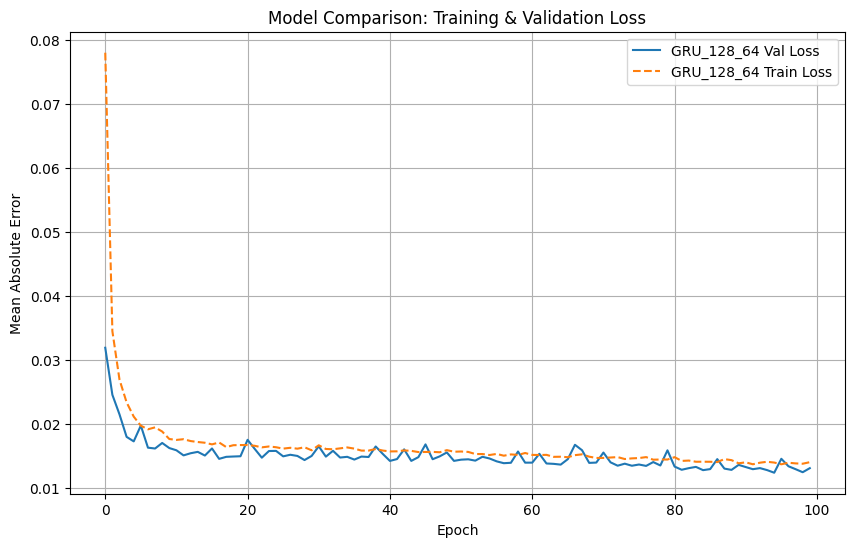

In [64]:
# Extract last training and validation losses from each history
summary = {}
for name, history in histories.items():
    last_train_loss = history.history['loss'][-1]
    last_val_loss = history.history['val_loss'][-1]
    summary[name] = {
        'train_loss': last_train_loss,
        'val_loss': last_val_loss
    }

# Print nicely
print("Final Losses (from last epoch):")
for name, losses in summary.items():
    print(f"{name:15s} -> Train: {losses['train_loss']:.5f}, Val: {losses['val_loss']:.5f}")

# Plot training & validation loss (looked this up)
plt.figure(figsize=(10,6))

for name, history in histories.items():
    plt.plot(history.history['val_loss'], label=f"{name} Val Loss")
    plt.plot(history.history['loss'], linestyle='--', label=f"{name} Train Loss")

plt.title("Model Comparison: Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Mean Absolute Error")
plt.legend()
plt.grid(True)
plt.show()

In [65]:
# Find the 61st element for all 10,000 test cases. OH NO! >:3 hehehehehe



def create_sequence_chunks(df, sensor_cols, seq_length):
    data = df[sensor_cols].values
    num_cases = len(data) // seq_length  # e.g., 600000 / 60 = 10000
    data = data[:num_cases * seq_length] # trim remainder if any

    # reshape into (num_cases, seq_length, num_features)
    X = data.reshape(num_cases, seq_length, len(sensor_cols))
    return X

X_test = create_sequence_chunks(df, sensor_cols, seq_length)
print("X_test shape:", X_test.shape)    # (10000, 60, 5)

# Predict the next (61st) timestep for each case
y_pred = models['GRU_128_64'].predict(X_test)
print("Predicted shape:", y_pred.shape)  # (10000, 5)

# (Optional) invert normalization to original scale
y_pred_original = scaler.inverse_transform(y_pred)

# Convert to DataFrame for inspection or saving
pred_df = pd.DataFrame(y_pred_original, columns=['sensor_1', 'sensor_2', 'sensor_3', 'sensor_4', 'sensor_5'])
pred_df.insert(0, 'sequence_id', range(0, len(pred_df)))
pred_df.to_csv('predictions.csv', index=False)

print(pred_df.head())

X_test shape: (10000, 60, 5)
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step
Predicted shape: (10000, 5)
   sequence_id  sensor_1  sensor_2  sensor_3  sensor_4  sensor_5
0            0 -0.058965 -0.354041  0.084440 -0.519977 -0.004108
1            1  0.765971  0.652790  0.848928  0.887112  0.849288
2            2 -0.415566 -0.103822 -0.464384 -0.050650 -0.055871
3            3  1.403712  1.293196  1.424016  1.292450  1.114211
4            4  1.449278  1.611512  1.198856  1.490903  1.205546
